In [30]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
from torch.nn.utils.prune import l1_unstructured, random_unstructured
import torch.nn.functional as F

from signal_gen.generate_harmonics import generate_dataset_time, generate_dataset_freq
from models.deepclean import DeepCleanAE, FFTDeepCleanAE

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def prune_model(model):
    
    with torch.no_grad():
        
        l1_unstructured(model.downsampler[0].conv, name='weight', amount=0.2)
        l1_unstructured(model.downsampler[1].conv, name='weight', amount=0.2)
        l1_unstructured(model.downsampler[2].conv, name='weight', amount=0.2)
        l1_unstructured(model.downsampler[3].conv, name='weight', amount=0.2)
        
        prune.remove(model.downsampler[0].conv, 'weight')
        prune.remove(model.downsampler[1].conv, 'weight')
        prune.remove(model.downsampler[2].conv, 'weight')
        prune.remove(model.downsampler[3].conv, 'weight')


In [31]:
sr = 1000   # sample rate (number of points sampled per second)
s = 10   # number of seconds
n = sr * s    # number of total time stamp samples

std_min = 10    
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3

train_size = 1000
eval_size = 100
freq = 1
max_num_harmonics = 10

X_train, Y_train, Y_onehot_train = generate_dataset_freq(train_size, n, s, sr, freq, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
X_eval, Y_eval, Y_onehot_eval = generate_dataset_freq(eval_size, n, s, sr, freq, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)


In [32]:
X_train = X_train.unsqueeze(dim=1).to(torch.float32)
Y_train = Y_train.to(torch.float32)
Y_onehot_train = Y_onehot_train.to(torch.float32)

X_eval = X_eval.unsqueeze(dim=1).to(torch.float32)
Y_eval = Y_eval.to(torch.float32)
Y_onehot_eval = Y_onehot_eval.to(torch.float32)

In [ ]:
# Model Instantiation
in_channels = 1
model = DeepCleanAE(in_channels)

training_loss = []
eval_loss = []

In [37]:
# dataset generation
batch_size = 64
train_dataset = TensorDataset(X_train, Y_onehot_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = TensorDataset(X_eval, Y_onehot_eval)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

# model.load_state_dict(torch.load("deepclean_model.pth"))
model.train()
data_for_viz = {}
do_pruning = False

# Loss function and optimizer
lambda_reg = 0.001
# criterion = nn.L1Loss()  # Suitable for classification tasks
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 200

# pruning related parameters
prune_every = 50
per_round_prune_ratio = 1 - (1 - 0.5) ** (
            1 / (num_epochs/prune_every)
        )
 
# Training loop
for epoch in range(num_epochs):
    
    running_loss = 0.0
    batch = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)   
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += lambda_reg * l1_norm
                
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    training_loss.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        eval_running_loss = 0
        for inputs, labels in eval_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += lambda_reg * l1_norm
            eval_running_loss += loss.item()
    eval_loss.append(eval_running_loss/len(eval_loader))
    
    with torch.no_grad():
        if do_pruning and (epoch+1) % prune_every == 0:
            print("pruning...")
            prune_model(model)
            print("number of zeros of downsample conv1: ", torch.sum(model.downsampler[0].conv.weight == 0).item())
        
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.10f}, Eval Loss: {eval_running_loss/len(eval_loader):.10f}')

Epoch [1/200], Train Loss: 0.0247084097, Eval Loss: 0.0220053550
Epoch [2/200], Train Loss: 0.0196458597, Eval Loss: 0.0186006865
Epoch [3/200], Train Loss: 0.0182825060, Eval Loss: 0.0180946225
Epoch [4/200], Train Loss: 0.0187462188, Eval Loss: 0.0180163514
Epoch [5/200], Train Loss: 0.0180172038, Eval Loss: 0.0184557727
Epoch [6/200], Train Loss: 0.0182882878, Eval Loss: 0.0181855680
Epoch [7/200], Train Loss: 0.0182843785, Eval Loss: 0.0179862482
Epoch [8/200], Train Loss: 0.0177658738, Eval Loss: 0.0189615395
Epoch [9/200], Train Loss: 0.0180972948, Eval Loss: 0.0180824464
Epoch [10/200], Train Loss: 0.0176345875, Eval Loss: 0.0181020666
Epoch [11/200], Train Loss: 0.0179144455, Eval Loss: 0.0178413168
Epoch [12/200], Train Loss: 0.0174604524, Eval Loss: 0.0178654967
Epoch [13/200], Train Loss: 0.0177226934, Eval Loss: 0.0168234203
Epoch [14/200], Train Loss: 0.0175592729, Eval Loss: 0.0171437589
Epoch [15/200], Train Loss: 0.0176152213, Eval Loss: 0.0175978225
Epoch [16/200], Tra

KeyboardInterrupt: 

(tensor([4950, 4960, 4970, 4980, 4990, 5010, 5020, 5030, 5040, 5050]),)
(tensor([4942, 4948, 4950, 4958, 4960, 4968, 4970, 4978, 4980, 4988, 4990, 4992,
        5000, 5008, 5010, 5012, 5018, 5020, 5022, 5028, 5030, 5038, 5040, 5042,
        5050, 5060, 5070, 5090]),)


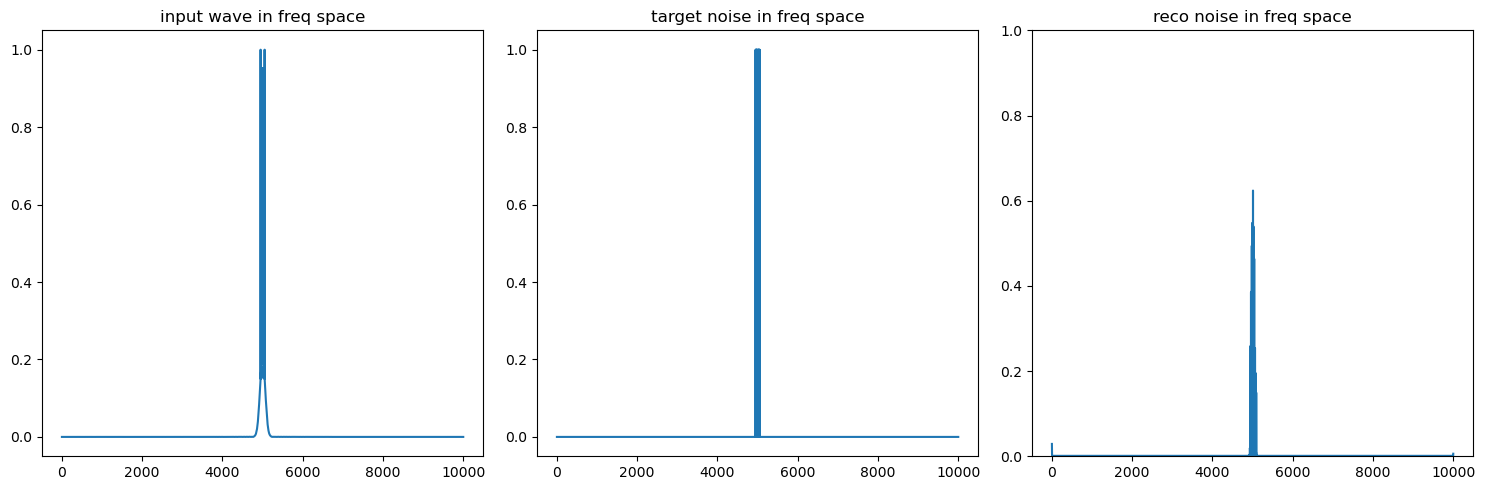

In [51]:
i = 5
# plt.plot(inputs.squeeze(dim=1)[i].detach().numpy())
# plt.show()
# plt.plot(labels[i].detach().numpy())
# plt.show()
# plt.plot(torch.sigmoid(outputs[i]).detach().numpy())
# plt.ylim(0,1)

import matplotlib.pyplot as plt
import numpy as np
print(torch.where(labels[i].detach()))
print(torch.where(torch.sigmoid(outputs[i].detach())>0.1))

# Create a figure and an array of 3 subplots arranged in a row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot 1: Sine wave
axs[0].plot(inputs.squeeze(dim=1)[i].detach().numpy())
axs[0].set_title('input wave in freq space')

# Plot 2: Cosine wave
axs[1].plot(labels[i].detach().numpy())
axs[1].set_title('target noise in freq space')

# Plot 3: Tangent wave
axs[2].plot(torch.sigmoid(outputs[i]).detach().numpy())
axs[2].set_title('reco noise in freq space')
axs[2].set_ylim(0, 1)  # Limit y-axis for tangent plot

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()



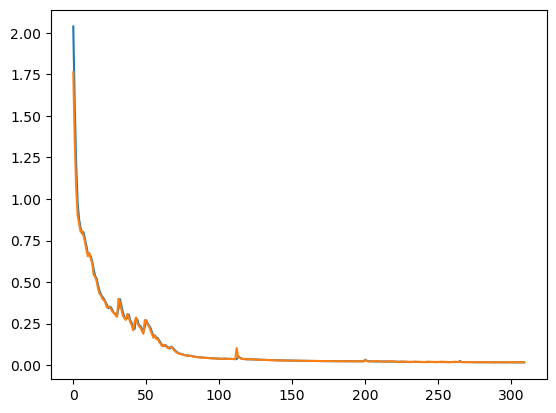

In [38]:
plt.plot(training_loss)
plt.plot(eval_loss)

In [52]:
sr = 1000   # sample rate (number of points sampled per second)
s = 10   # number of seconds
n = sr * s    # number of total time stamp samples

std_min = 10    
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3

train_size = 1000
eval_size = 100
freq = 1
max_num_harmonics = 10

X_train, Y_train = generate_dataset_time(train_size, n, s, sr, freq, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
X_eval, Y_eval = generate_dataset_time(eval_size, n, s, sr, freq, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)


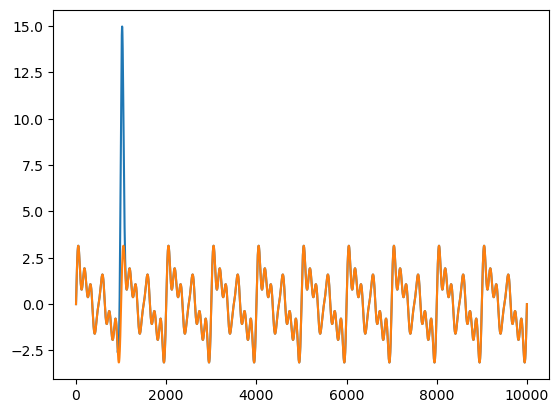

In [53]:
plt.plot(X_train[0].detach().numpy())
plt.plot(Y_train[0].detach().numpy())

In [54]:
X_train = X_train.unsqueeze(dim=1).to(torch.float32)
Y_train = Y_train.to(torch.float32)
print(X_train.shape)
print(Y_train.shape)

X_eval = X_eval.unsqueeze(dim=1).to(torch.float32)
Y_eval = Y_eval.to(torch.float32)

torch.Size([1000, 1, 10000])
torch.Size([1000, 10000])


In [ ]:
# Model Instantiation
in_channels = 1
model2 = DeepCleanAE(in_channels)

training_loss2 = []
eval_loss2 = []

In [88]:
# dataset generation
batch_size = 64
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

eval_dataset = TensorDataset(X_eval, Y_eval)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

# model.load_state_dict(torch.load("deepclean_model.pth"))

# pruning parameters
prune_every = 50
do_pruning = False

data_for_viz = {}
# Loss function and optimizer
lambda_reg = 0.001
criterion = nn.L1Loss()  # MAE loss
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    batch = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model2(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # l1_norm = sum(p.abs().sum() for p in model2.parameters())
        # loss += lambda_reg * l1_norm
                
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    training_loss2.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        eval_running_loss = 0
        for inputs, labels in eval_loader:
            print("label ", labels.shape)
            outputs = model2(inputs)
            print("output ", outputs.shape)
            loss = criterion(outputs, labels)
            eval_running_loss += loss.item()
    eval_loss2.append(eval_running_loss/len(eval_loader))
    
    with torch.no_grad():
        if do_pruning and (epoch) % prune_every == 0:
            print("pruning...")
            prune_model(model2)
            print("number of zeros of downsample conv1: ", torch.sum(model2.downsampler[0].conv.weight == 0).item())
            
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.10f}, Eval Loss: {eval_running_loss/len(eval_loader):.10f}')

label  torch.Size([64, 10000])
output  torch.Size([64, 10000])
label  torch.Size([36, 10000])
output  torch.Size([36, 10000])
Epoch [1/200], Train Loss: 0.1292255726, Eval Loss: 0.0940883644
label  torch.Size([64, 10000])
output  torch.Size([64, 10000])
label  torch.Size([36, 10000])
output  torch.Size([36, 10000])
Epoch [2/200], Train Loss: 0.1194739984, Eval Loss: 0.1085293368


KeyboardInterrupt: 

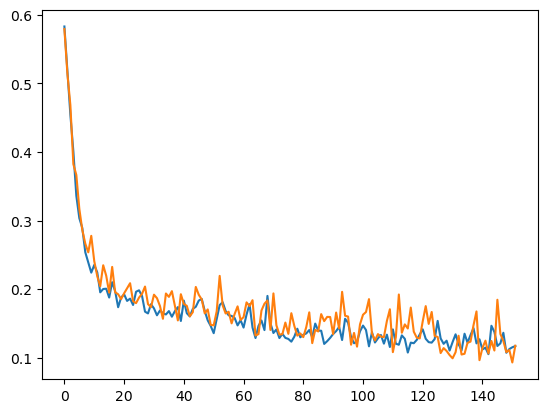

In [68]:
plt.plot(training_loss2)
plt.plot(eval_loss2)

In [90]:
viz_eval_loader = iter(eval_loader)

In [91]:
inputs_test, labels_test = next(viz_eval_loader)
outputs_test = model2(inputs_test)
print(criterion(outputs_test, labels_test))


tensor(0.1139, grad_fn=<MeanBackward0>)


In [87]:
outputs_test.shape

torch.Size([64, 10000])

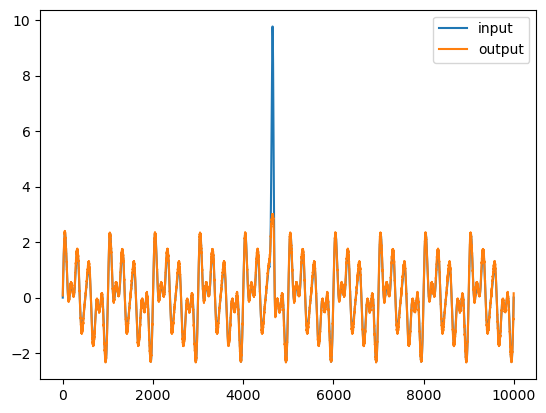

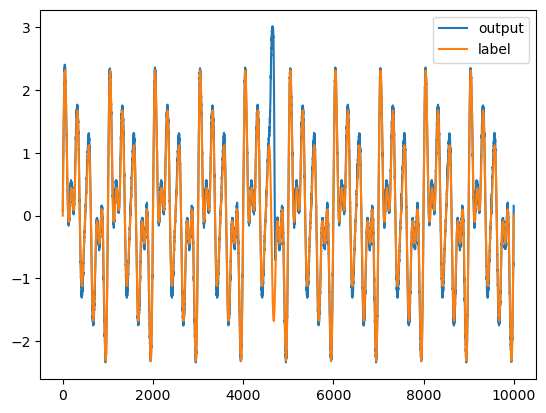

In [119]:
ev = 15
# plt.plot(inputs.squeeze(dim=1)[ev].detach().numpy())
plt.plot(inputs_test.squeeze(dim=1)[ev].detach().numpy(), label="input")
plt.plot(outputs_test[ev].detach().numpy(), label="output")
# plt.plot(labels_test[ev].detach().numpy(), label="label")
plt.legend()
plt.show()
plt.plot(outputs_test[ev].detach().numpy(), label="output")
plt.plot(labels_test[ev].detach().numpy(), label="label")
plt.legend()
plt.show()


In [125]:
import torch
import scipy.signal as scipy_signal

def build_empty_signal(n, sr):
    t = np.arange(n) / sr
    x = np.zeros(n)
    return x, t

def gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length):
    signal_length = len(x)
    
    for _ in range(num_pulses):
        std = np.random.uniform(std_min, std_max)
        amp = np.random.uniform(amp_min, amp_max)
        
        window_length = int(2 * std_length * std)  # Ensure the window length is odd
        if window_length % 2 == 1: window_length -= 1
                
        window = scipy_signal.windows.gaussian(window_length, std=std)
        window = amp*window
        
        pos = np.random.randint(window_length, signal_length-window_length//2)
        
        start = pos - (window_length // 2) 
        end = pos + (window_length // 2 )
        
        window_segment = window[:end - start]  # Adjust the length of the window segment
        x[start:end] += window_segment

    return x, amp

import random


def generate_noise_harmonic(N, A, duration, sample_rate, freq, max_num_harmonics):
    
    t = np.linspace(0, duration, int(sample_rate*duration))  # Time axis
    num_harmonics = random.randint(2, max_num_harmonics)    # at least 2 frequencies in this harmonic
    
    noise = np.zeros_like(t)
    
    for har in range(1,num_harmonics):
        amp = random.uniform(0, A/10)
        noise += amp*np.sin(2*np.pi*freq*har*t)
        
    return noise, num_harmonics


def generate_dataset_freq(size, n, s, sr, freqs, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length):
    X = []
    Y = []  
    Y_onehot = []   # labels that are delta functions in frequency space
    
    for i in range(size):
        x, t = build_empty_signal(n, sr)
        x, amp = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
        
        fft_noises = None
        fft_signal = np.fft.fft(x)
        for freq in freqs:
            noise, num_harmonics = generate_noise_harmonic(n, amp, s, sr, freq, max_num_harmonics)
            fft_noise = np.fft.fft(noise)
            if fft_noises is None:
                fft_noises = fft_noise
            else:
                fft_noises += fft_noise
            
        inp = (abs(fft_signal+fft_noises) - min(abs(fft_signal+fft_noises))) / (max(abs(fft_signal+fft_noises)) - min(abs(fft_signal+fft_noises)))
        label = abs((fft_noises - min(fft_noises)) / (max(fft_noises) - min(fft_noises)))
        
        inp = np.fft.fftshift(inp)
        label = np.fft.fftshift(label)
        
        f = np.fft.fftfreq(n, d=1/sr)

        # label one hot
        f_shifted = np.fft.fftshift(f)
        y_onehot = [0]*n
        
        # for j in range(1, num_harmonics):
        #     freq_idx = np.where(abs(f_shifted) == j*freq)[0]
        #     for f_id in freq_idx:
        #         y_onehot[f_id] = 1
            
        X.append(inp)
        Y.append(label) # labels that are delta functions in frequency space
        Y_onehot.append(y_onehot)   # one hot labels 
        
    return torch.tensor(X), torch.tensor(Y), torch.tensor(Y_onehot)

def generate_dataset_time(size, n, s, sr, freqs, max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length):
    X = []
    X_noises = []
    Y = []  
    # Y_onehot = []   # labels that are delta functions in frequency space
    
    for i in range(size):
        x, t = build_empty_signal(n, sr)
        x, amp = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
        
        X_noise = []
        noises = None
        for freq in freqs: 
            noise, _ = generate_noise_harmonic(n, amp, s, sr, freq, max_num_harmonics)
            X_noise.append(noise)
            if noises is None:
                noises = noise
            else:
                noises += noise
                
        X_noises.append(X_noise)
        # fft_signal = np.fft.fft(x)
        # fft_noise = np.fft.fft(noise)
        
        # inp = (abs(fft_signal+fft_noise) - min(abs(fft_signal+fft_noise))) / (max(abs(fft_signal+fft_noise)) - min(abs(fft_signal+fft_noise)))
        # label = abs((fft_noise - min(fft_noise)) / (max(fft_noise) - min(fft_noise)))
        
        # inp = np.fft.fftshift(inp)
        # label = np.fft.fftshift(label)
        
        # f = np.fft.fftfreq(n, d=1/sr)

        # label one hot
        # f_shifted = np.fft.fftshift(f)
        # y_onehot = [0]*n
        
        # for j in range(1, num_harmonics):
        #     freq_idx = np.where(abs(f_shifted) == j*freq)[0]
        #     for f_id in freq_idx:
        #         y_onehot[f_id] = 1
            
        X.append(noise+x)
        Y.append(noise) # labels that are delta functions in frequency space
        # Y_onehot.append(y_onehot)   # one hot labels 
    plt.plot(X[-1])
    plt.plot(Y[-1])
    return torch.tensor(X), torch.tensor(Y), X_noises
    

    

In [25]:
test_size = 10
freq_test = 1
X_test, Y_test, _ = generate_dataset_freq(test_size, n, s, sr, [freq_test], max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)


torch.Size([1, 1, 10000])
torch.Size([1, 10000])
torch.Size([10000])


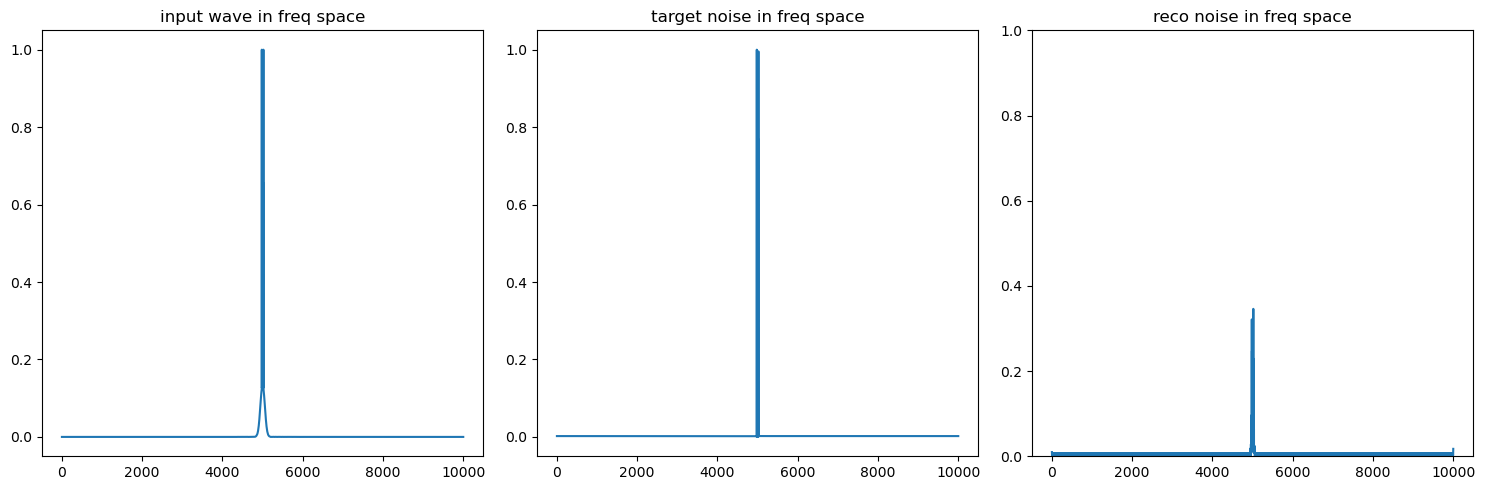

In [26]:
model.eval()
iev = 2
inputs = X_test[iev].unsqueeze(dim=0).unsqueeze(dim=0).to(torch.float32)
label = Y_test[iev]
print(inputs.shape)
output = model(inputs)
print(output.shape)
print(label.shape)
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an array of 3 subplots arranged in a row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot 1: Sine wave
axs[0].plot(inputs[0].squeeze(dim=0).detach().numpy())
axs[0].set_title('input wave in freq space')

# Plot 2: Cosine wave
axs[1].plot(label.detach().numpy())
axs[1].set_title('target noise in freq space')

# Plot 3: Tangent wave
axs[2].plot(torch.sigmoid(output).squeeze(dim=0).detach().numpy())
axs[2].set_title('reco noise in freq space')
axs[2].set_ylim(0, 1)  # Limit y-axis for tangent plot

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()



In [27]:
prob_pred = torch.sigmoid(output).squeeze(dim=0)
torch.where(prob_pred > 0.2)

(tensor([4980, 4984, 4986, 5012, 5016, 5018]),)

In [28]:
torch.where(label > 0.1)

(tensor([4980, 4990, 5010, 5020]),)

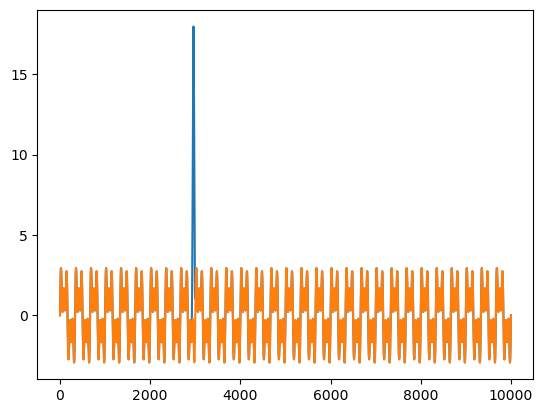

In [126]:
test_size = 10
freq_test = 1
X_test_more_freq, Y_test_more_freq, X_noises = generate_dataset_time(test_size, n, s, sr, [freq_test,3], max_num_harmonics, std_min, std_max, amp_min, amp_max, num_pulses, std_length)


torch.Size([1, 1, 10000])
torch.Size([1, 10000])
torch.Size([10000])


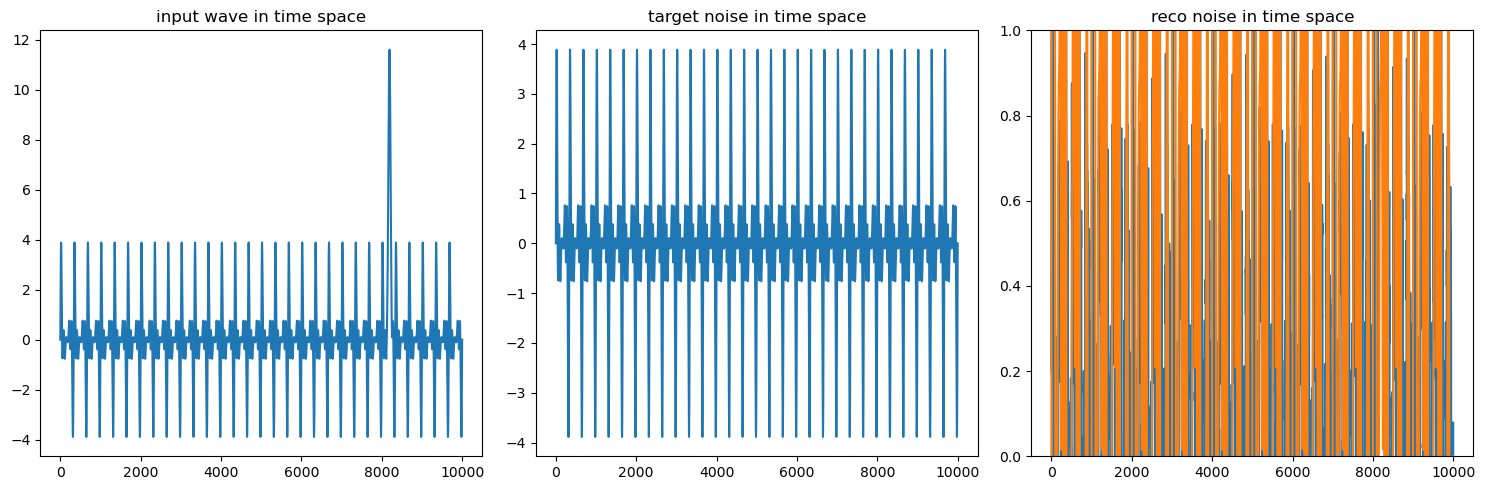

In [133]:
model.eval()
iev = 1
inputs = X_test_more_freq[iev].unsqueeze(dim=0).unsqueeze(dim=0).to(torch.float32)
label = Y_test_more_freq[iev]
separate_label = X_noises[iev]

print(inputs.shape)
output = model2(inputs)
print(output.shape)
print(label.shape)
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an array of 3 subplots arranged in a row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot 1: Sine wave
axs[0].plot(inputs[0].squeeze(dim=0).detach().numpy())
axs[0].set_title('input wave in time space')

# Plot 2: Cosine wave
axs[1].plot(label.detach().numpy())
axs[1].set_title('target noise in time space')

# Plot 3: Tangent wave
axs[2].plot(output.squeeze(dim=0).detach().numpy())
axs[2].plot(separate_label[0])
axs[2].set_title('reco noise in time space')
axs[2].set_ylim(0, 1)  # Limit y-axis for tangent plot

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()



tensor(1.2173, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.4932, dtype=torch.float64, grad_fn=<MeanBackward0>)


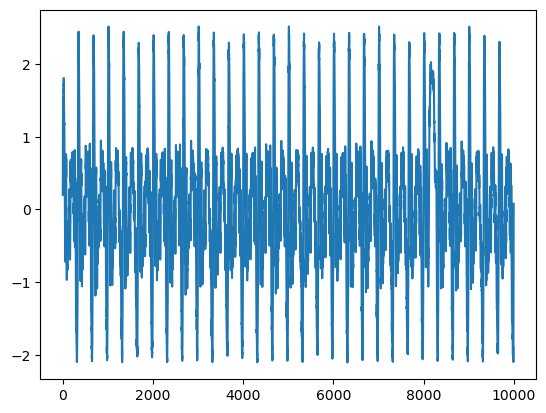

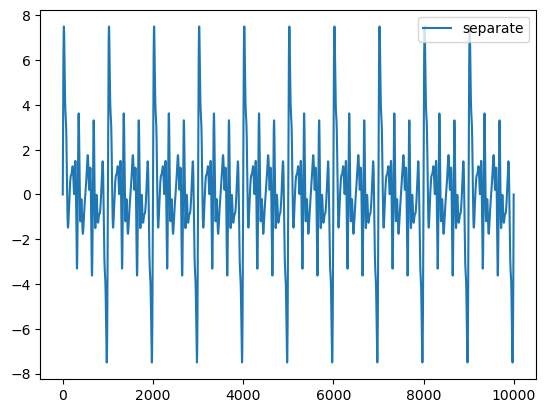

In [145]:
print(criterion(output, torch.tensor(separate_label[0]).unsqueeze(dim=0)))
print(criterion(output, torch.tensor(separate_label[1]).unsqueeze(dim=0)))

plt.plot(output.squeeze(dim=0).detach().numpy(), label="output")
plt.show()
plt.plot(separate_label[0], label="separate")
plt.legend()

In [154]:
model.downsampler[1].conv

Conv1d(8, 16, kernel_size=(7,), stride=(2,), padding=(3,))

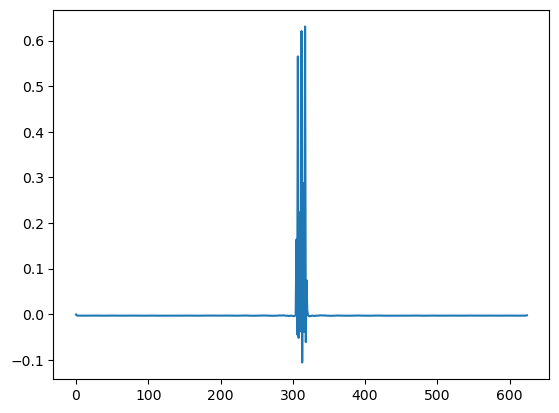

In [197]:
# plt.plot(model.encodings["downsample"][0][46])
plt.plot(model.encodings["downsample"][6][47])
# for i in range(45,50):
#     plt.plot(model.encodings["downsample"][0][i])

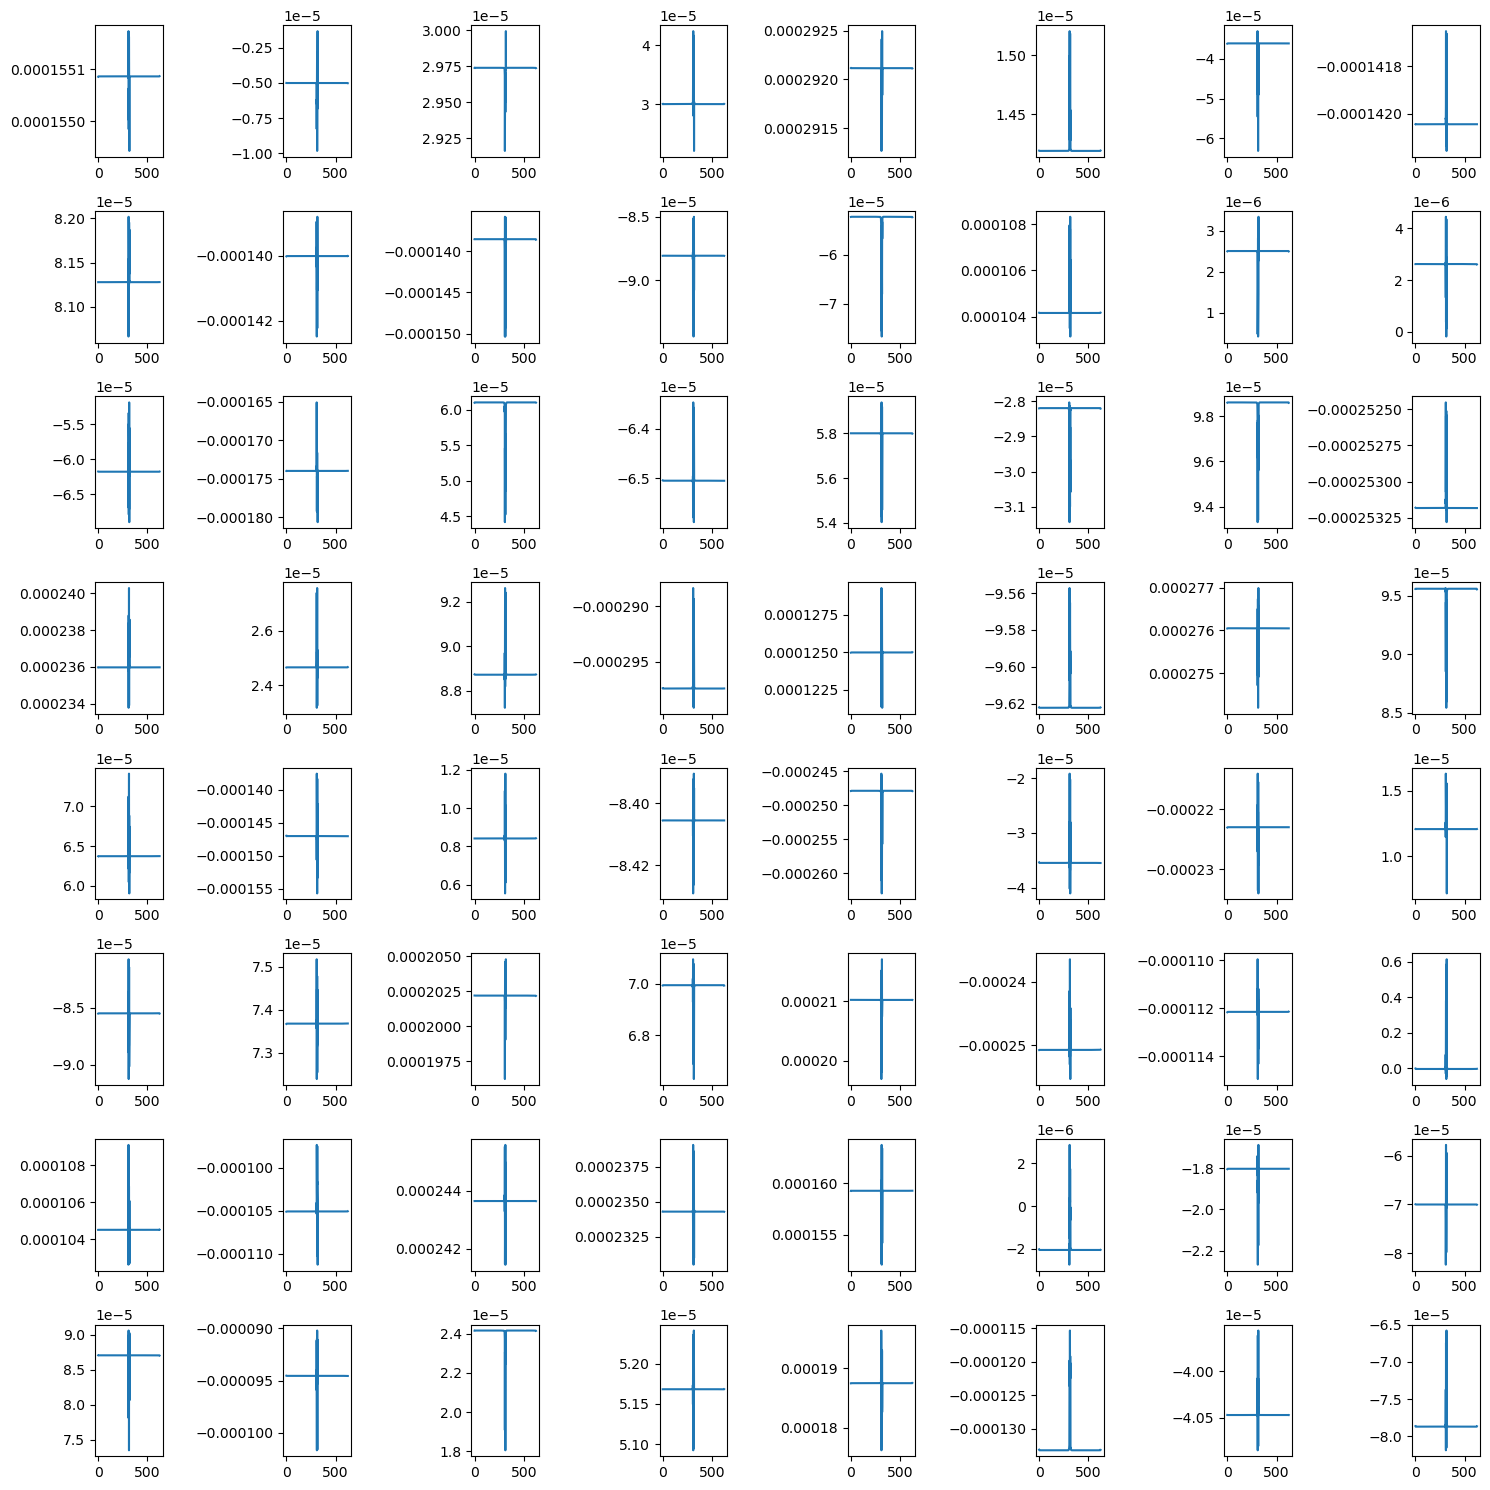

In [163]:
# Define the figure and axes with a grid of 8x8 (64 plots)
fig, axs = plt.subplots(8, 8, figsize=(15, 15))  # Create a figure with 64 subplots

# Generate data and plot in each subplot
for i in range(8):  # Rows
    for j in range(8):  # Columns
        axs[i, j].plot(model.encodings["downsample"][0][i*8+j])

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [165]:
model.encodings["downsample"][0][0]

array([0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015509,
       0.00015509, 0.00015509, 0.00015509, 0.00015509, 0.00015